In [15]:
import numpy as np
from matplotlib import pyplot as plt

In [17]:
def distance(x1,y1,x2,y2): 
    return np.sqrt((x2-x1)**2 + (y2-y1)**2) 

In [37]:
plot_every = 1000

In [21]:
def main(): 

    Nx = 400
    Ny = 100 
    tau = 0.53
    Nt = 3000

    #Lattice speeds and weights
    NL = 9 
    cxs = np.array([0, 0, 1, 1, 1, 0, -1, -1, -1])
    cys = np.array([0, 1, 1, 0, -1, -1, -1, 0, 1])
    weights = np.array([4/9, 1/9, 1/36, 1/9, 1/36, 1/9, 1/36, 1/9, 1/36])

    #Initial conditions
    F = np.ones([Ny, Nx, NL]) + 0.1* np.random.rand(Ny, Nx, NL)
    F[:,:,3] = 2.3 #Can be modified

    cylinder = np.full((Ny, Nx), False)

    for y in range(0,Ny):
        for x in range(0,Nx):
            if (distance(Nx//4, Ny//2, x, y)) < 13:
                cylinder[y][x] = True
    #Main loop 
    for it in range(Nt):
        #print(it)

        F[:, -1, [6,7,8]] = F[:, -2, [6,7,8]]
        F[:, 0, [2,3,4]] = F[:, 1, [2,3,4]]
        for i, cx, cy in zip(range(NL), cxs, cys):
            F[:,:,i] = np.roll(F[:,:,i], cx, axis = 1)
            F[:,:,i] = np.roll(F[:,:,i], cy, axis = 0)
        
        bndryF = F[cylinder, :]
        bndryF = bndryF[:, [0, 5, 6, 7, 8, 1, 2, 3, 4]]

        #Fluid variables
        rho = np.sum(F, 2)
        ux = np.sum(F*cxs, 2) / rho
        uy = np.sum(F*cys, 2) / rho

        
        F[cylinder, :] = bndryF
        ux[cylinder] = 0
        uy[cylinder] = 0

        # Collision
        Feq = np.zeros(F.shape)
        for i, cx, cy, w in zip(range(NL), cxs, cys, weights):
            Feq[:,:,i] = rho * w * (1 + 3 * (cx*ux + cy*uy) + 9 * (cx*ux + cy*uy)**2 / 2 - 3 * (ux**2 + uy**2)/2) 
        F = F + -(1/tau) * (F-Feq)
        if (it%plot_every ==0):
         #plt.imshow(np.sqrt(ux**2+uy**2))
         dfydx = ux[2:, 1:-1] - ux[0:-2, 1:-1]
         dfxdy = uy[1:-1,2:] - uy[1:-1, 0:-2]
         curl = dfydx - dfxdy
         plt.imshow(curl, cmap = 'bwr')
         plt.pause(0.01)
         plt.cla()

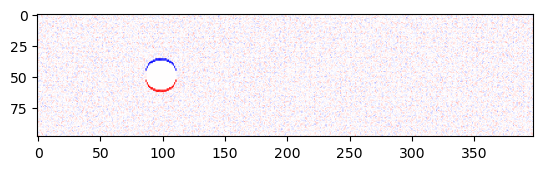

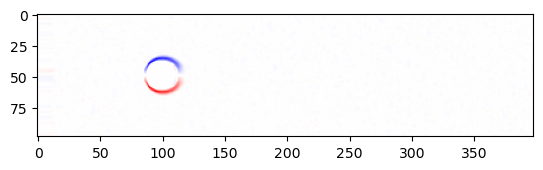

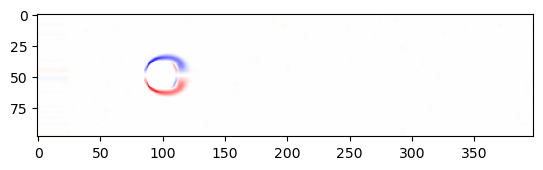

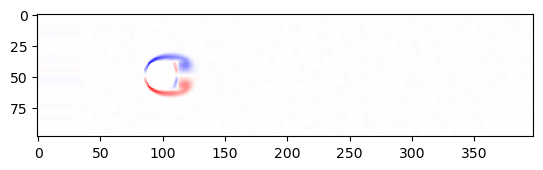

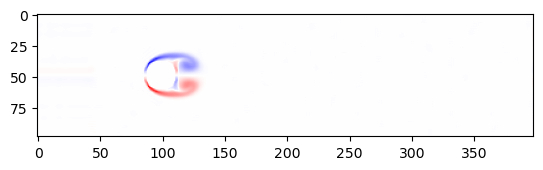

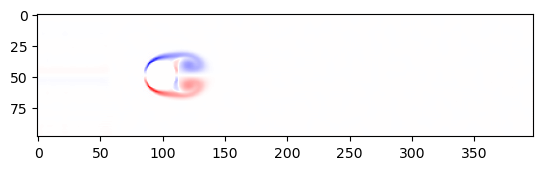

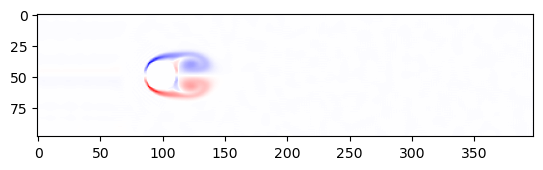

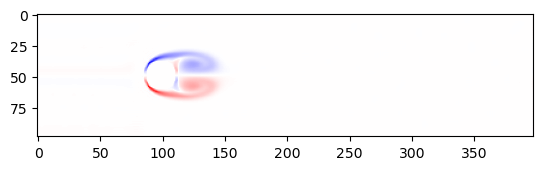

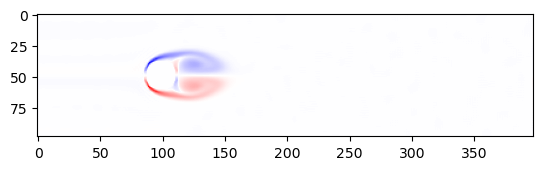

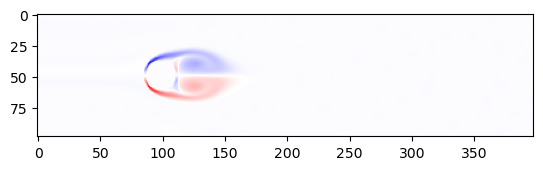

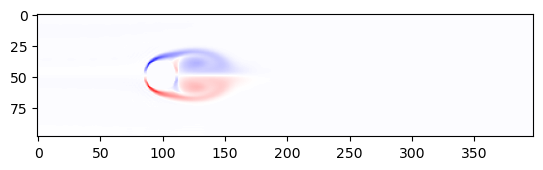

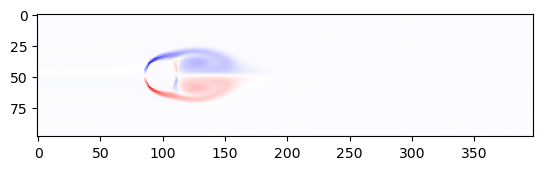

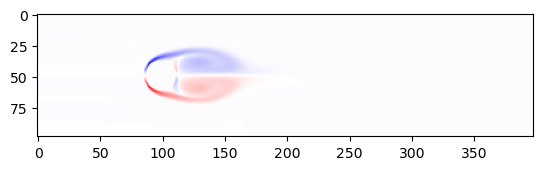

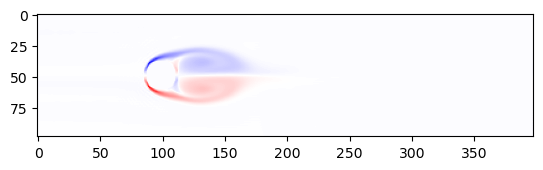

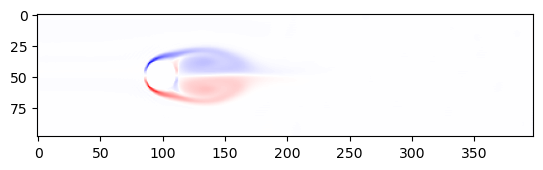

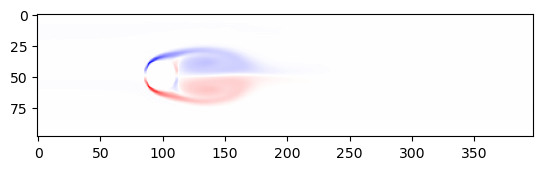

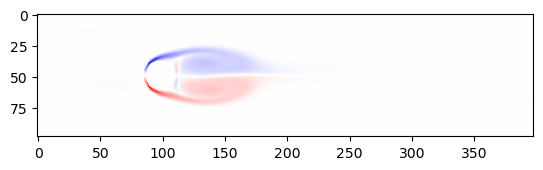

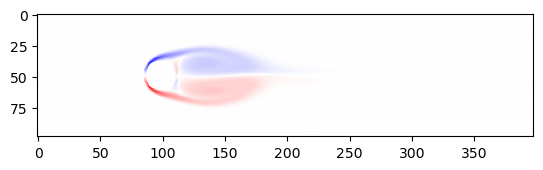

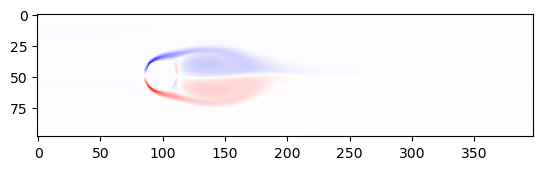

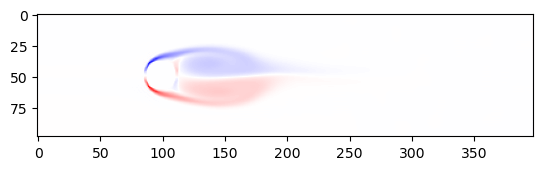

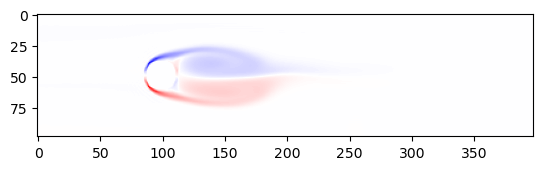

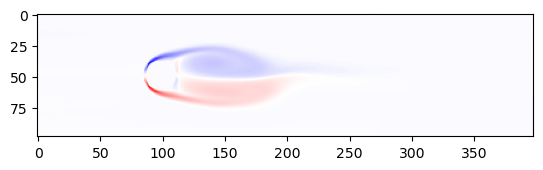

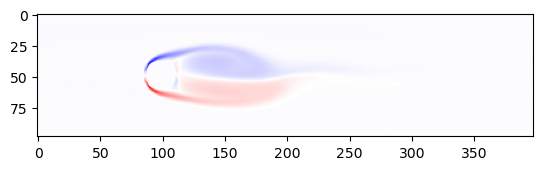

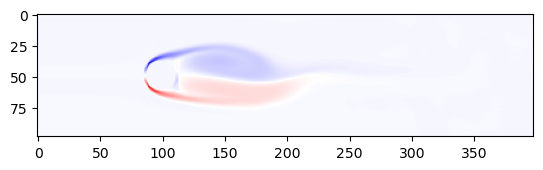

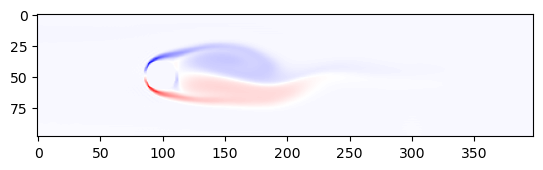

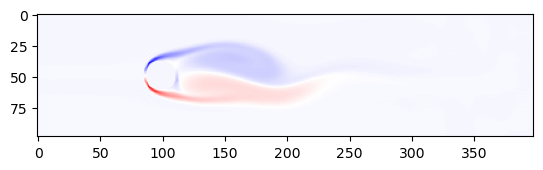

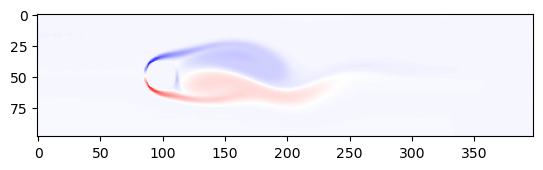

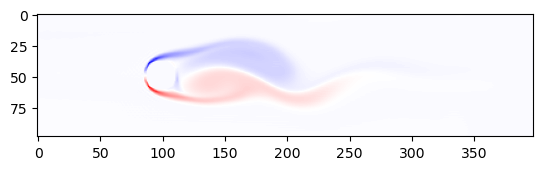

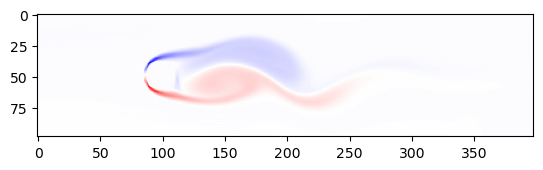

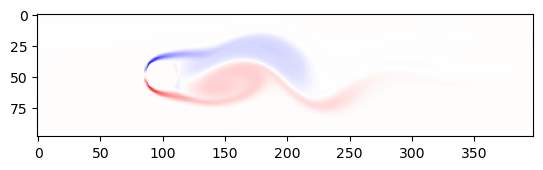

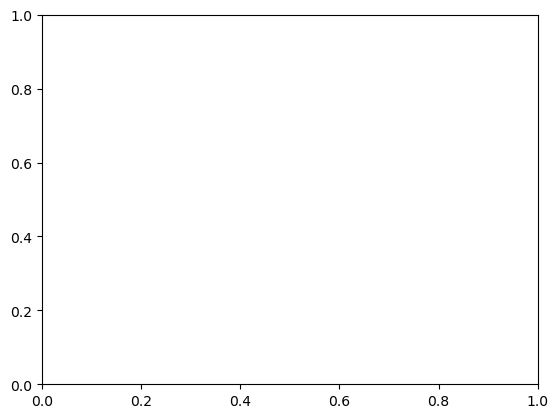

In [29]:
main()

In [23]:
from matplotlib.path import Path
def load_airfoil_mask(Nx, Ny, filename,
                      chord_frac=0.5,
                      offset=(100, 50)):
    """
    filename   : path to your .dat (e.g. 'seligdatfile.txt')
    chord_frac : fraction of Nx occupied by chord length
    offset     : (x0, y0) in grid coords to place the leading edge
    """
    # ── 1) read in the raw coords (skip header line)
    coords = np.loadtxt(filename, skiprows=1)
    x_norm, y_norm = coords[:,0], coords[:,1]
    
    # ── 2) scale from [0,1] → grid units
    chord = chord_frac * Nx
    xg = x_norm * chord + offset[0]
    yg = y_norm * chord * (Ny/Nx) + offset[1]
    
    # ── 3) rasterize polygon into boolean mask
    path = Path(np.column_stack((xg, yg)))
    xv, yv = np.meshgrid(np.arange(Nx), np.arange(Ny))
    pts = np.vstack((xv.ravel(), yv.ravel())).T
    mask = path.contains_points(pts).reshape((Ny, Nx))
    return mask

In [11]:
filename = '/Users/irisb/Documents/seligdatfile.txt'
load_airfoil_mask(400,100,filename)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [50]:
def main_airfoil(): 

    Nx = 800
    Ny = 100 
    tau = 0.53
    Nt = 30000
    
    #Lattice speeds and weights
    NL = 9 
    cxs = np.array([0, 0, 1, 1, 1, 0, -1, -1, -1])
    cys = np.array([0, 1, 1, 0, -1, -1, -1, 0, 1])
    weights = np.array([4/9, 1/9, 1/36, 1/9, 1/36, 1/9, 1/36, 1/9, 1/36])

    obstacle_mask = load_airfoil_mask(
        Nx, Ny,
        filename,
        chord_frac=0.5,
        offset=(100, Ny//2 - 10)
    )
    #Initial conditions
    F = np.ones([Ny, Nx, NL]) + 0.1* np.random.rand(Ny, Nx, NL)
    F[:,:,3] = 2.3 #Can be modified


    #Main loop 
    for it in range(Nt):
        #print(it)

        F[:, -1, [6,7,8]] = F[:, -2, [6,7,8]]
        F[:, 0, [2,3,4]] = F[:, 1, [2,3,4]]
        for i, cx, cy in zip(range(NL), cxs, cys):
            F[:,:,i] = np.roll(F[:,:,i], cx, axis = 1)
            F[:,:,i] = np.roll(F[:,:,i], cy, axis = 0)
        
        bndryF = F[obstacle_mask, :]
        bndryF = bndryF[:, [0, 5, 6, 7, 8, 1, 2, 3, 4]]

        #Fluid variables
        rho = np.sum(F, 2)
        ux = np.sum(F*cxs, 2) / rho
        uy = np.sum(F*cys, 2) / rho

        
        F[obstacle_mask, :] = bndryF
        ux[obstacle_mask] = 0
        uy[obstacle_mask] = 0

        # Collision
        Feq = np.zeros(F.shape)
        for i, cx, cy, w in zip(range(NL), cxs, cys, weights):
            Feq[:,:,i] = rho * w * (1 + 3 * (cx*ux + cy*uy) + 9 * (cx*ux + cy*uy)**2 / 2 - 3 * (ux**2 + uy**2)/2) 
        F = F + -(1/tau) * (F-Feq)
        if (it%plot_every ==0):
         #plt.imshow(np.sqrt(ux**2+uy**2))
         dfydx = ux[2:, 1:-1] - ux[0:-2, 1:-1]
         dfxdy = uy[1:-1,2:] - uy[1:-1, 0:-2]
         curl = dfydx - dfxdy
         plt.imshow(curl, cmap = 'bwr')
         plt.pause(0.01)
         plt.cla()

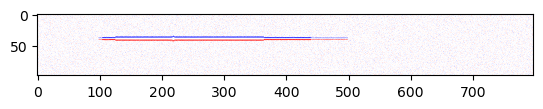

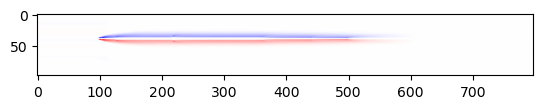

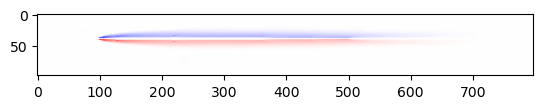

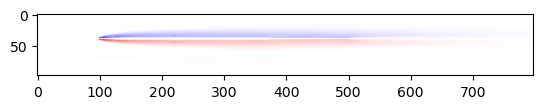

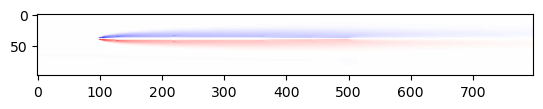

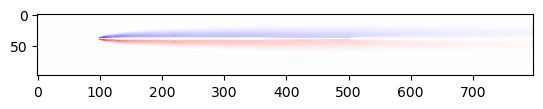

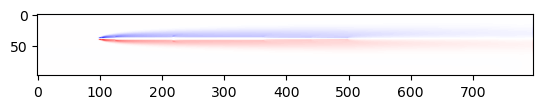

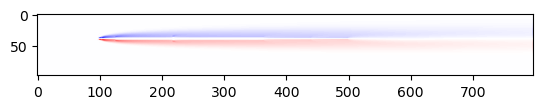

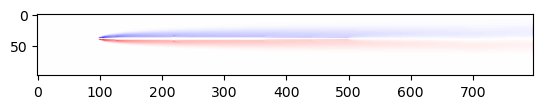

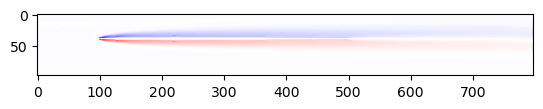

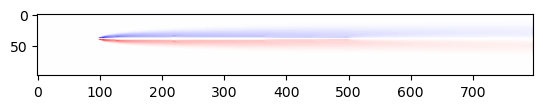

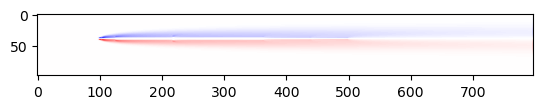

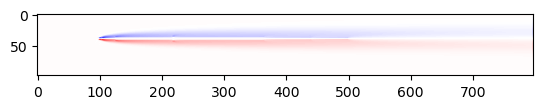

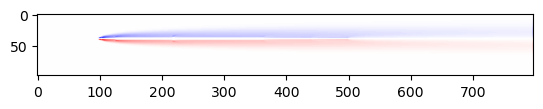

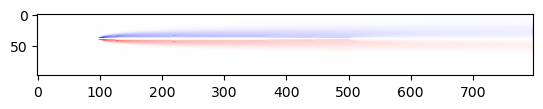

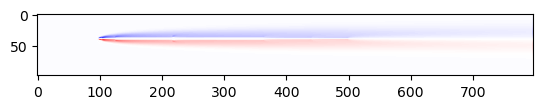

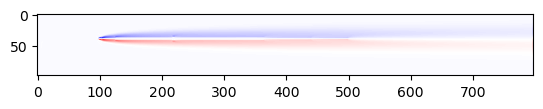

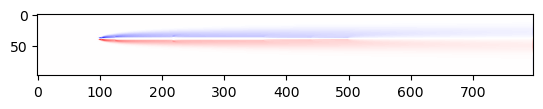

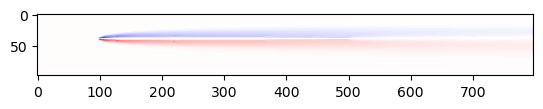

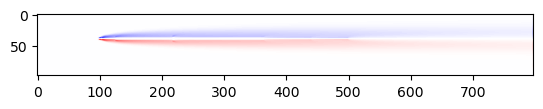

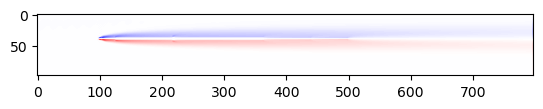

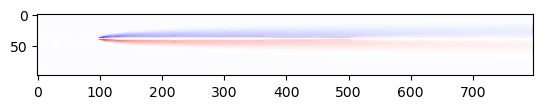

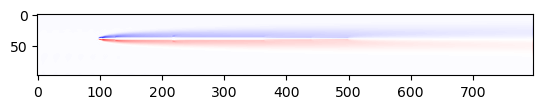

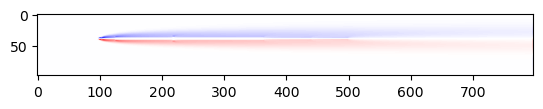

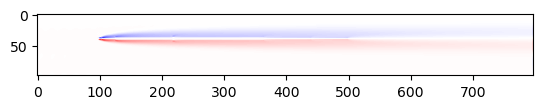

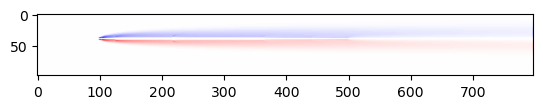

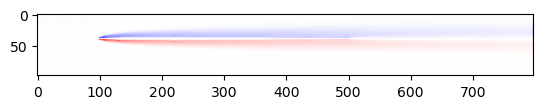

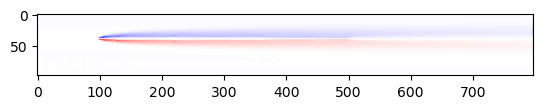

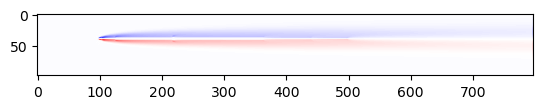

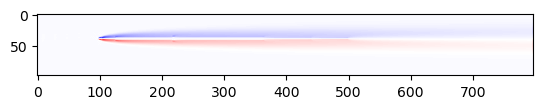

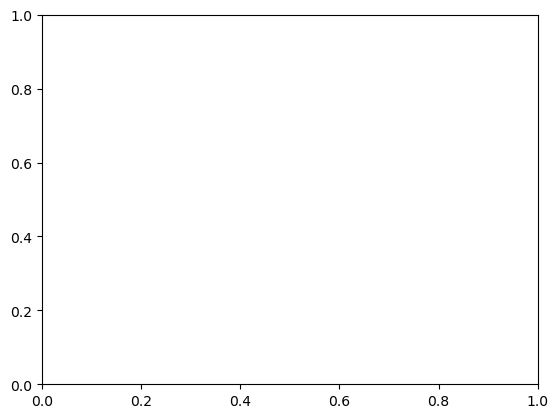

In [51]:
main_airfoil()